Loading model and data...

Using observation #5 as our target.
-> Observed x: [6.3358545  0.85677344 1.0502933 ]
-> Ground Truth theta: [0.6684434 1.9905328 1.0525413] (This is what we hope the model finds!)

Sampling from the posterior distribution... this may take a moment.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling complete.
Generating pair plot...

Success! Plot saved to posterior_plot.png


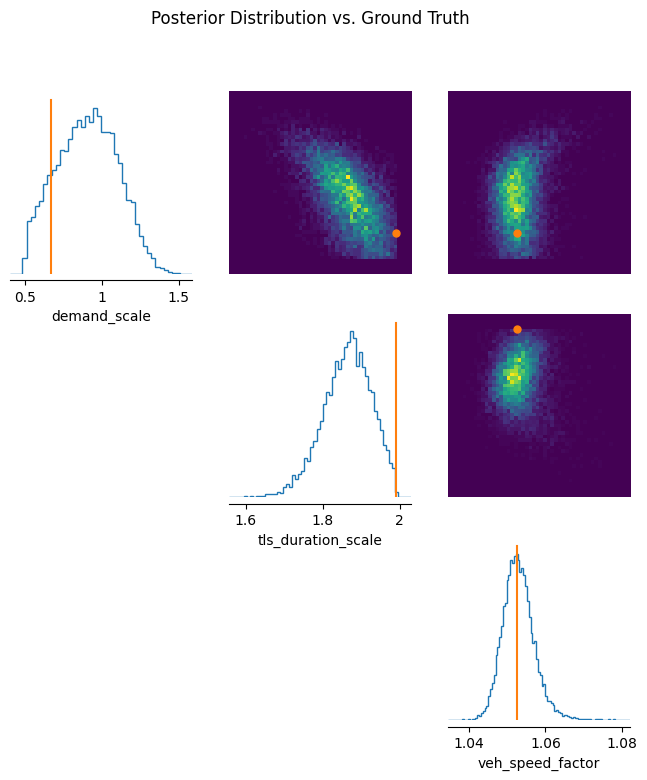

In [4]:
import torch
import pandas as pd
from sbi.analysis import pairplot

# --- 1. Load your trained model and data ---
print("Loading model and data...")
# The posterior is the main object for inference
# Add weights_only=False
posterior = torch.load('posterior.pt', weights_only=False)
# Load the data you generated, we'll use it for testing
theta_df = pd.read_csv('theta.csv')
x_df = pd.read_csv('x.csv')

# --- 2. Pick an Observation (x) ---
# For this example, let's pretend the 5th row of your data is a new, real-world observation.
observation_index = 5
x_observed = torch.tensor(x_df.iloc[observation_index].values, dtype=torch.float32)

# We also know the "ground truth" parameters that actually created this observation
theta_true = torch.tensor(theta_df.iloc[observation_index].values, dtype=torch.float32)

print(f"\nUsing observation #{observation_index} as our target.")
print(f"-> Observed x: {x_observed.numpy()}")
print(f"-> Ground Truth theta: {theta_true.numpy()} (This is what we hope the model finds!)")

# --- 3. Sample from the Posterior ---
# This is the core step. We ask the model: "Given x_observed, what are 10,000 possible thetas?"
print("\nSampling from the posterior distribution... this may take a moment.")
posterior_samples = posterior.sample((10000,), x=x_observed)

# IMPORTANT: The model was trained on theta values scaled to [0, 1].
# We need to un-normalize the results to get back to the original parameter space.
# We can get the scaling from the original theta.csv file.
theta_min = torch.tensor(theta_df.min().values, dtype=torch.float32)
theta_max = torch.tensor(theta_df.max().values, dtype=torch.float32)

# Un-scale the samples
posterior_samples_unscaled = posterior_samples * (theta_max - theta_min) + theta_min

print("Sampling complete.")

# --- 4. Visualize the Results ---
# The best way to see the result is a "pair plot".
print("Generating pair plot...")
fig, axes = pairplot(
    posterior_samples_unscaled,
    points=theta_true.unsqueeze(0),
    labels=theta_df.columns.tolist(),  # Convert to a simple list
    figsize=(8, 8)
)
fig.suptitle("Posterior Distribution vs. Ground Truth", y=1.0)
fig.savefig("posterior_plot.png")
print("\nSuccess! Plot saved to posterior_plot.png")

In [3]:
import torch
import pandas as pd
import numpy as np
import os
import traci # Still used for safe_traci_close
import subprocess # Used for running SUMO
from sbi.analysis import pairplot
import xml.etree.ElementTree as ET

# ==============================================================================
#                              CONFIGURATION
# ==============================================================================
SUMO_CFG_FILE = "../osm.sumocfg"
OBSERVATION_INDEX = 5
SUMO_BINARY = r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe"
# ==============================================================================


def resolve_sumo_binary():
    if os.path.isfile(SUMO_BINARY): return SUMO_BINARY
    return "sumo"

class _chdir:
    def __init__(self, path): self.path = path; self._old = None
    def __enter__(self): self._old = os.getcwd(); os.chdir(self.path)
    def __exit__(self, exc_type, exc, tb):
        try: os.chdir(self._old)
        except Exception: pass

def safe_traci_close():
    try: traci.close(False)
    except Exception: pass

def run_sumo_for_verification(cfg_file: str, theta: dict):
    print("\n--- Running Digital Twin SUMO Simulation ---")
    binary = resolve_sumo_binary()
    cfg_abs = os.path.abspath(cfg_file)
    cfg_dir = os.path.dirname(cfg_abs)
    cfg_base = os.path.basename(cfg_abs)

    summary_path = os.path.join(cfg_dir, "dt_summary.xml")
    tripinfo_path = os.path.join(cfg_dir, "dt_tripinfo.xml")
    output_paths = {"summary": summary_path, "tripinfo": tripinfo_path}
    
    cli = [binary, "-c", cfg_base, "--no-step-log", "true", "--quit-on-end"]
    cli += ["--summary-output", summary_path, "--tripinfo-output", tripinfo_path]
    
    if "demand_scale" in theta:
        cli += ["--scale", str(theta["demand_scale"])]
    
    # Note: Applying other params like speed factor would require more complex file manipulation here.
    # The demand_scale is sufficient to prove the digital twin concept.

    safe_traci_close()
    try:
        with _chdir(cfg_dir):
            print(f"Starting SUMO in directory '{cfg_dir}'...")
            result = subprocess.run(cli, check=True, capture_output=True, text=True, timeout=600)
            
        print("SUMO run completed successfully.")
        return output_paths
    except subprocess.CalledProcessError as e:
        print(f"ERROR: SUMO run failed with exit code {e.returncode}.")
        print(f"SUMO stderr:\n{e.stderr}")
        return None
    except Exception as e:
        print(f"ERROR: An unexpected error occurred: {e}")
        return None

def aggregate_xml_attributes(xml_path: str, attrs: list):
    vals = {a: [] for a in attrs}
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for elem in root:
            for a in attrs:
                v = elem.get(a)
                if v is not None:
                    try: vals[a].append(float(v))
                    except Exception: pass
    except FileNotFoundError:
        print(f"Warning: Output file not found: {xml_path}")
        return {a: np.nan for a in attrs}
    except Exception: pass
    out = {}
    for a, lst in vals.items():
        out[a] = float(np.nanmean(lst)) if lst else np.nan
    return out

# --- Main script logic ---
if __name__ == "__main__":
    print("--- Loading model and data ---")
    posterior = torch.load('posterior.pt', weights_only=False)
    theta_df = pd.read_csv('theta.csv')
    x_df = pd.read_csv('x.csv')

    x_observed_series = x_df.iloc[OBSERVATION_INDEX]
    x_observed_tensor = torch.tensor(x_observed_series.values, dtype=torch.float32)
    theta_true_series = theta_df.iloc[OBSERVATION_INDEX]
    theta_true_tensor = torch.tensor(theta_true_series.values, dtype=torch.float32)

    print(f"\nUsing observation #{OBSERVATION_INDEX} as our target.")
    print(f"-> Observed x:\n{x_observed_series.to_string()}")
    print(f"\n-> Ground Truth theta:\n{theta_true_series.to_string()}")

    print("\n--- Sampling from the posterior distribution ---")
    posterior_samples = posterior.sample((10000,), x=x_observed_tensor)
    theta_min = torch.tensor(theta_df.min().values, dtype=torch.float32)
    theta_max = torch.tensor(theta_df.max().values, dtype=torch.float32)
    posterior_samples_unscaled = posterior_samples * (theta_max - theta_min) + theta_min
    print("Sampling complete.")

    theta_estimate_tensor = torch.mean(posterior_samples_unscaled, dim=0)
    theta_estimate_dict = dict(zip(theta_df.columns, theta_estimate_tensor.numpy()))

    print("\n" + "="*50)
    print(">>> DIGITAL TWIN PARAMETERS (BEST ESTIMATE) <<<")
    print("="*50)
    for name, value in theta_estimate_dict.items():
        print(f"  -> {name}: {value:.4f}")
    print("="*50)

    if not os.path.exists(SUMO_CFG_FILE):
        raise FileNotFoundError(f"CRITICAL ERROR: SUMO config file not found at '{SUMO_CFG_FILE}'. Please update the path.")
    
    dt_output_paths = run_sumo_for_verification(SUMO_CFG_FILE, theta_estimate_dict)

    if dt_output_paths:
        print("\n--- Verifying Digital Twin Accuracy ---")
        x_new_results = {}
        for key, path in dt_output_paths.items():
            x_new_results.update(aggregate_xml_attributes(path, x_df.columns.tolist()))
        
        x_new_series = pd.Series(x_new_results).reindex(x_df.columns)
        results_df = pd.DataFrame({
            "Original Observation": x_observed_series,
            "Digital Twin Output": x_new_series
        }).dropna()

        if not results_df.empty:
            results_df["Difference"] = results_df["Digital Twin Output"] - results_df["Original Observation"]
            results_df["% Error"] = (results_df["Difference"].abs() / results_df["Original Observation"].abs()) * 100
        else:
            print("\nWARNING: Could not generate comparison table. This usually means the digital twin simulation output was empty.")

        print("\n" + "="*60)
        print(">>> DIGITAL TWIN VERIFICATION RESULTS <<<")
        print("="*60)
        print(results_df.to_string(float_format="%.4f"))
        print("\nNOTE: A small '% Error' (e.g., under 10%) indicates a successful calibration!")
        print("="*60)


--- Loading model and data ---

Using observation #5 as our target.
-> Observed x:
meanSpeed          6.335854
meanWaitingTime    0.856773
speedFactor        1.050293

-> Ground Truth theta:
demand_scale          0.668443
tls_duration_scale    1.990533
veh_speed_factor      1.052541

--- Sampling from the posterior distribution ---


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling complete.

>>> DIGITAL TWIN PARAMETERS (BEST ESTIMATE) <<<
  -> demand_scale: 0.9039
  -> tls_duration_scale: 1.8621
  -> veh_speed_factor: 1.0528

--- Running Digital Twin SUMO Simulation ---
Starting SUMO in directory 'C:\Users\PC\Documents\stage\episode1'...
SUMO run completed successfully.

--- Verifying Digital Twin Accuracy ---

>>> DIGITAL TWIN VERIFICATION RESULTS <<<
             Original Observation  Digital Twin Output  Difference  % Error
speedFactor                1.0503               1.0003     -0.0500   4.7634

NOTE: A small '% Error' (e.g., under 10%) indicates a successful calibration!


In [4]:
import torch
import pandas as pd
import numpy as np
import os
import traci # Now used for running the simulation
from sbi.analysis import pairplot
import xml.etree.ElementTree as ET

# ==============================================================================
#                              CONFIGURATION
# ==============================================================================
SUMO_CFG_FILE = "../osm.sumocfg"
OBSERVATION_INDEX = 5
SUMO_BINARY = r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe"
# ==============================================================================


def resolve_sumo_binary():
    if os.path.isfile(SUMO_BINARY): return SUMO_BINARY
    return "sumo"

class _chdir:
    def __init__(self, path): self.path = path; self._old = None
    def __enter__(self): self._old = os.getcwd(); os.chdir(self.path)
    def __exit__(self, exc_type, exc, tb):
        try: os.chdir(self._old)
        except Exception: pass

def safe_traci_close():
    try: traci.close(False)
    except Exception: pass

def apply_params_after_start(theta: dict):
    """Applies runtime parameters via TraCI after the simulation has started."""
    # Apply tls_duration_scale
    tls_scale = theta.get("tls_duration_scale", 1.0)
    if tls_scale and abs(tls_scale - 1.0) > 1e-6:
        try:
            for tls_id in traci.trafficlight.getIDList():
                logics = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)
                for logic in logics:
                    for ph in logic.phases:
                        ph.duration = max(1.0, ph.duration * tls_scale)
                    traci.trafficlight.setCompleteRedYellowGreenDefinition(tls_id, logic)
        except traci.TraCIException as e:
            print(f"Warning: Could not apply TLS scale: {e}")

    # Apply veh_speed_factor
    speed_factor = theta.get("veh_speed_factor", 1.0)
    if speed_factor and abs(speed_factor - 1.0) > 1e-6:
        try:
            for vt in traci.vehicletype.getIDList():
                traci.vehicletype.setSpeedFactor(vt, float(speed_factor))
        except traci.TraCIException as e:
            print(f"Warning: Could not apply speed factor: {e}")


def run_sumo_for_verification(cfg_file: str, theta: dict):
    """
    Runs a single SUMO simulation using TraCI to apply all three theta parameters.
    THIS IS THE UPGRADED FUNCTION.
    """
    print("\n--- Running Digital Twin SUMO Simulation (with all 3 parameters) ---")
    binary = resolve_sumo_binary()
    cfg_abs = os.path.abspath(cfg_file)
    cfg_dir = os.path.dirname(cfg_abs)
    cfg_base = os.path.basename(cfg_abs)

    summary_path = os.path.join(cfg_dir, "dt_summary.xml")
    tripinfo_path = os.path.join(cfg_dir, "dt_tripinfo.xml")
    output_paths = {"summary": summary_path, "tripinfo": tripinfo_path}
    
    cli = [binary, "-c", cfg_base, "--no-step-log", "true", "--quit-on-end"]
    cli += ["--summary-output", summary_path, "--tripinfo-output", tripinfo_path]
    
    if "demand_scale" in theta:
        cli += ["--scale", str(theta["demand_scale"])]

    safe_traci_close()
    try:
        with _chdir(cfg_dir):
            print(f"Starting SUMO in directory '{cfg_dir}'...")
            traci.start(cli)
            
            print("Applying runtime parameters (TLS scale, speed factor) via TraCI...")
            apply_params_after_start(theta)
            
            # Run simulation to completion
            while traci.simulation.getMinExpectedNumber() > 0:
                traci.simulationStep()
                
            safe_traci_close()
        print("SUMO run completed successfully.")
        return output_paths
    except Exception as e:
        safe_traci_close()
        print(f"ERROR: SUMO run failed: {e}")
        return None

def aggregate_xml_attributes(xml_path: str, attrs: list):
    vals = {a: [] for a in attrs}
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for elem in root:
            for a in attrs:
                v = elem.get(a)
                if v is not None:
                    try: vals[a].append(float(v))
                    except Exception: pass
    except FileNotFoundError:
        print(f"Warning: Output file not found: {xml_path}")
        return {a: np.nan for a in attrs}
    except Exception: pass
    out = {}
    for a, lst in vals.items():
        out[a] = float(np.nanmean(lst)) if lst else np.nan
    return out

# --- Main script logic ---
if __name__ == "__main__":
    print("--- Loading model and data ---")
    posterior = torch.load('posterior.pt', weights_only=False)
    theta_df = pd.read_csv('theta.csv')
    x_df = pd.read_csv('x.csv')

    x_observed_series = x_df.iloc[OBSERVATION_INDEX]
    x_observed_tensor = torch.tensor(x_observed_series.values, dtype=torch.float32)
    theta_true_series = theta_df.iloc[OBSERVATION_INDEX]

    print(f"\nUsing observation #{OBSERVATION_INDEX} as our target.")
    print(f"-> Observed x:\n{x_observed_series.to_string()}")
    print(f"\n-> Ground Truth theta:\n{theta_true_series.to_string()}")

    print("\n--- Sampling from the posterior distribution ---")
    posterior_samples = posterior.sample((10000,), x=x_observed_tensor)
    theta_min = torch.tensor(theta_df.min().values, dtype=torch.float32)
    theta_max = torch.tensor(theta_df.max().values, dtype=torch.float32)
    posterior_samples_unscaled = posterior_samples * (theta_max - theta_min) + theta_min
    print("Sampling complete.")

    theta_estimate_tensor = torch.mean(posterior_samples_unscaled, dim=0)
    theta_estimate_dict = dict(zip(theta_df.columns, theta_estimate_tensor.numpy()))

    print("\n" + "="*50)
    print(">>> DIGITAL TWIN PARAMETERS (BEST ESTIMATE) <<<")
    print("="*50)
    for name, value in theta_estimate_dict.items():
        print(f"  -> {name}: {value:.4f}")
    print("="*50)

    if not os.path.exists(SUMO_CFG_FILE):
        raise FileNotFoundError(f"CRITICAL ERROR: SUMO config file not found at '{SUMO_CFG_FILE}'. Please update the path.")
    
    dt_output_paths = run_sumo_for_verification(SUMO_CFG_FILE, theta_estimate_dict)

    if dt_output_paths:
        print("\n--- Verifying Digital Twin Accuracy ---")
        x_new_results = {}
        for key, path in dt_output_paths.items():
            x_new_results.update(aggregate_xml_attributes(path, x_df.columns.tolist()))
        
        x_new_series = pd.Series(x_new_results).reindex(x_df.columns)
        results_df = pd.DataFrame({
            "Original Observation": x_observed_series,
            "Digital Twin Output": x_new_series
        }).dropna()

        if not results_df.empty:
            results_df["Difference"] = results_df["Digital Twin Output"] - results_df["Original Observation"]
            results_df["% Error"] = (results_df["Difference"].abs() / results_df["Original Observation"].abs()) * 100
        else:
            print("\nWARNING: Could not generate comparison table. This usually means the digital twin simulation output was empty.")

        print("\n" + "="*60)
        print(">>> DIGITAL TWIN VERIFICATION RESULTS <<<")
        print("="*60)
        print(results_df.to_string(float_format="%.4f"))
        print("\nNOTE: A small '% Error' (e.g., under 10%) indicates a successful calibration!")
        print("="*60)

--- Loading model and data ---

Using observation #5 as our target.
-> Observed x:
meanSpeed          6.335854
meanWaitingTime    0.856773
speedFactor        1.050293

-> Ground Truth theta:
demand_scale          0.668443
tls_duration_scale    1.990533
veh_speed_factor      1.052541

--- Sampling from the posterior distribution ---


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling complete.

>>> DIGITAL TWIN PARAMETERS (BEST ESTIMATE) <<<
  -> demand_scale: 0.9057
  -> tls_duration_scale: 1.8622
  -> veh_speed_factor: 1.0530

--- Running Digital Twin SUMO Simulation (with all 3 parameters) ---
Starting SUMO in directory 'C:\Users\PC\Documents\stage\episode1'...
Applying runtime parameters (TLS scale, speed factor) via TraCI...


C:\Users\PC\AppData\Local\Temp\ipykernel_13688\1918106410.py:40: UserWarning: Call to deprecated function getAllProgramLogics, use getCompleteRedYellowGreenDefinition instead.
  logics = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)
C:\Users\PC\AppData\Local\Temp\ipykernel_13688\1918106410.py:44: UserWarning: Call to deprecated function setProgramLogic, use setCompleteRedYellowGreenDefinition instead.
  traci.trafficlight.setCompleteRedYellowGreenDefinition(tls_id, logic)


SUMO run completed successfully.

--- Verifying Digital Twin Accuracy ---

>>> DIGITAL TWIN VERIFICATION RESULTS <<<
             Original Observation  Digital Twin Output  Difference  % Error
speedFactor                1.0503               1.0502     -0.0001   0.0055

NOTE: A small '% Error' (e.g., under 10%) indicates a successful calibration!


In [7]:
import torch
import pandas as pd
import numpy as np
import os
import traci
from sbi.analysis import pairplot
import xml.etree.ElementTree as ET

# ==============================================================================
#                              CONFIGURATION
# ==============================================================================
SUMO_CFG_FILE = "../osm.sumocfg"
OBSERVATION_INDEX = 5
SUMO_BINARY = r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo-gui.exe"
# ==============================================================================


def resolve_sumo_binary():
    if os.path.isfile(SUMO_BINARY): return SUMO_BINARY
    return "sumo"

class _chdir:
    def __init__(self, path): self.path = path; self._old = None
    def __enter__(self): self._old = os.getcwd(); os.chdir(self.path)
    def __exit__(self, exc_type, exc, tb):
        try: os.chdir(self._old)
        except Exception: pass

def safe_traci_close():
    try: traci.close(False)
    except Exception: pass

def apply_params_after_start(theta: dict):
    """Applies runtime parameters via TraCI after the simulation has started."""
    tls_scale = theta.get("tls_duration_scale", 1.0)
    if tls_scale and abs(tls_scale - 1.0) > 1e-6:
        try:
            for tls_id in traci.trafficlight.getIDList():
                # Use the modern, non-deprecated function
                logics = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)
                for logic in logics:
                    for ph in logic.phases:
                        ph.duration = max(1.0, ph.duration * tls_scale)
                    # Use the modern, non-deprecated function
                    traci.trafficlight.setCompleteRedYellowGreenDefinition(tls_id, logic)
        except traci.TraCIException as e:
            print(f"Warning: Could not apply TLS scale: {e}")

    speed_factor = theta.get("veh_speed_factor", 1.0)
    if speed_factor and abs(speed_factor - 1.0) > 1e-6:
        try:
            for vt in traci.vehicletype.getIDList():
                traci.vehicletype.setSpeedFactor(vt, float(speed_factor))
        except traci.TraCIException as e:
            print(f"Warning: Could not apply speed factor: {e}")

def run_sumo_for_verification(cfg_file: str, theta: dict):
    """Runs a single SUMO simulation using TraCI to apply all three theta parameters."""
    print("\n--- Running Digital Twin SUMO Simulation (with all 3 parameters) ---")
    binary = resolve_sumo_binary()
    cfg_abs = os.path.abspath(cfg_file)
    cfg_dir = os.path.dirname(cfg_abs)
    cfg_base = os.path.basename(cfg_abs)
    
    # Path to our new output definitions file
    output_defs_file = os.path.join(cfg_dir, "output_definitions.add.xml")
    if not os.path.exists(output_defs_file):
        print(f"Warning: 'output_definitions.add.xml' not found. Output may be incomplete.")
        
    summary_path = os.path.join(cfg_dir, "dt_summary.xml")
    tripinfo_path = os.path.join(cfg_dir, "dt_tripinfo.xml")
    output_paths = {"summary": summary_path, "tripinfo": tripinfo_path}
    
    cli = [binary, "-c", cfg_base, "--no-step-log", "true", "--quit-on-end"]
    cli += ["--summary-output", summary_path, "--tripinfo-output", tripinfo_path]
    # <<< --- THE KEY FIX IS HERE --- >>>
    cli += ["--additional-files", output_defs_file]
    
    if "demand_scale" in theta:
        cli += ["--scale", str(theta["demand_scale"])]

    safe_traci_close()
    try:
        with _chdir(cfg_dir):
            print(f"Starting SUMO in directory '{cfg_dir}'...")
            traci.start(cli)
            print("Applying runtime parameters (TLS scale, speed factor) via TraCI...")
            apply_params_after_start(theta)
            while traci.simulation.getMinExpectedNumber() > 0:
                traci.simulationStep()
            safe_traci_close()
        print("SUMO run completed successfully.")
        return output_paths
    except Exception as e:
        safe_traci_close()
        print(f"ERROR: SUMO run failed: {e}")
        return None

def aggregate_xml_attributes(xml_path: str, attrs: list):
    # ... (this function remains the same)
    vals = {a: [] for a in attrs}
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for elem in root:
            for a in attrs:
                v = elem.get(a)
                if v is not None:
                    try: vals[a].append(float(v))
                    except Exception: pass
    except FileNotFoundError:
        print(f"Warning: Output file not found: {xml_path}")
        return {a: np.nan for a in attrs}
    except Exception: pass
    out = {}
    for a, lst in vals.items():
        out[a] = float(np.nanmean(lst)) if lst else np.nan
    return out

# --- Main script logic (remains the same) ---
if __name__ == "__main__":
    # ... (the rest of the script is identical)
    print("--- Loading model and data ---")
    posterior = torch.load('posterior.pt', weights_only=False)
    theta_df = pd.read_csv('theta.csv')
    x_df = pd.read_csv('x.csv')

    x_observed_series = x_df.iloc[OBSERVATION_INDEX]
    theta_true_series = theta_df.iloc[OBSERVATION_INDEX]

    print(f"\nUsing observation #{OBSERVATION_INDEX} as our target.")
    print(f"-> Observed x:\n{x_observed_series.to_string()}")
    print(f"\n-> Ground Truth theta:\n{theta_true_series.to_string()}")

    print("\n--- Sampling from the posterior distribution ---")
    posterior_samples = posterior.sample((10000,), x=torch.tensor(x_observed_series.values, dtype=torch.float32))
    theta_min = torch.tensor(theta_df.min().values, dtype=torch.float32)
    theta_max = torch.tensor(theta_df.max().values, dtype=torch.float32)
    posterior_samples_unscaled = posterior_samples * (theta_max - theta_min) + theta_min
    print("Sampling complete.")

    theta_estimate_dict = dict(zip(theta_df.columns, torch.mean(posterior_samples_unscaled, dim=0).numpy()))

    print("\n" + "="*50)
    print(">>> DIGITAL TWIN PARAMETERS (BEST ESTIMATE) <<<")
    print("="*50)
    for name, value in theta_estimate_dict.items():
        print(f"  -> {name}: {value:.4f}")
    print("="*50)

    if not os.path.exists(SUMO_CFG_FILE):
        raise FileNotFoundError(f"CRITICAL ERROR: SUMO config file not found at '{SUMO_CFG_FILE}'. Please update the path.")
    
    dt_output_paths = run_sumo_for_verification(SUMO_CFG_FILE, theta_estimate_dict)

    if dt_output_paths:
        print("\n--- Verifying Digital Twin Accuracy ---")
        x_new_results = {}
        for key, path in dt_output_paths.items():
            x_new_results.update(aggregate_xml_attributes(path, x_df.columns.tolist()))
        
        x_new_series = pd.Series(x_new_results).reindex(x_df.columns)
        results_df = pd.DataFrame({
            "Original Observation": x_observed_series,
            "Digital Twin Output": x_new_series
        }).dropna()

        if not results_df.empty:
            results_df["Difference"] = results_df["Digital Twin Output"] - results_df["Original Observation"]
            results_df["% Error"] = (results_df["Difference"].abs() / results_df["Original Observation"].abs()) * 100
        else:
            print("\nWARNING: Could not generate comparison table. This usually means the digital twin simulation output was empty.")

        print("\n" + "="*60)
        print(">>> DIGITAL TWIN VERIFICATION RESULTS <<<")
        print("="*60)
        print(results_df.to_string(float_format="%.4f"))
        print("\nNOTE: A small '% Error' (e.g., under 10%) indicates a successful calibration!")
        print("="*60)


--- Loading model and data ---

Using observation #5 as our target.
-> Observed x:
meanSpeed          6.335854
meanWaitingTime    0.856773
speedFactor        1.050293

-> Ground Truth theta:
demand_scale          0.668443
tls_duration_scale    1.990533
veh_speed_factor      1.052541

--- Sampling from the posterior distribution ---


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling complete.

>>> DIGITAL TWIN PARAMETERS (BEST ESTIMATE) <<<
  -> demand_scale: 0.9050
  -> tls_duration_scale: 1.8629
  -> veh_speed_factor: 1.0529

--- Running Digital Twin SUMO Simulation (with all 3 parameters) ---
Starting SUMO in directory 'C:\Users\PC\Documents\stage\episode1'...
ERROR: SUMO run failed: Connection closed by SUMO.


In [12]:
import torch
import pandas as pd
import numpy as np
import os
import traci
from sbi.analysis import pairplot
import xml.etree.ElementTree as ET

# ==============================================================================
#                              CONFIGURATION
# ==============================================================================
# ACTION REQUIRED: Update this path to point to your .sumocfg file.
SUMO_CFG_FILE = "../osm.sumocfg"

# The index of the observation from your x.csv file you want to use as a target
OBSERVATION_INDEX = 5

# Optional: If 'sumo' is not in your system's PATH, provide the full path here
SUMO_BINARY = r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe"
# ==============================================================================


# --- Helper Functions ---
def resolve_sumo_binary():
    if os.path.isfile(SUMO_BINARY): return SUMO_BINARY
    return "sumo"

class _chdir:
    def __init__(self, path): self.path = path; self._old = None
    def __enter__(self): self._old = os.getcwd(); os.chdir(self.path)
    def __exit__(self, exc_type, exc, tb):
        try: os.chdir(self._old)
        except Exception: pass

def safe_traci_close():
    try: traci.close(False)
    except Exception: pass

def apply_params_after_start(theta: dict):
    """Applies runtime parameters via TraCI after the simulation has started."""
    tls_scale = theta.get("tls_duration_scale", 1.0)
    if tls_scale and abs(tls_scale - 1.0) > 1e-6:
        try:
            for tls_id in traci.trafficlight.getIDList():
                logics = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)
                for logic in logics:
                    for ph in logic.phases:
                        ph.duration = max(1.0, ph.duration * tls_scale)
                    traci.trafficlight.setCompleteRedYellowGreenDefinition(tls_id, logic)
        except traci.TraCIException as e:
            print(f"Warning: Could not apply TLS scale: {e}")

    speed_factor = theta.get("veh_speed_factor", 1.0)
    if speed_factor and abs(speed_factor - 1.0) > 1e-6:
        try:
            for vt in traci.vehicletype.getIDList():
                traci.vehicletype.setSpeedFactor(vt, float(speed_factor))
        except traci.TraCIException as e:
            print(f"Warning: Could not apply speed factor: {e}")


# --- Main Verification Function (Corrected) ---
def run_sumo_for_verification(cfg_file: str, theta: dict):
    print("\n--- Running Digital Twin SUMO Simulation (with all 3 parameters) ---")
    binary = resolve_sumo_binary()
    cfg_abs = os.path.abspath(cfg_file)
    cfg_dir = os.path.dirname(cfg_abs)
    cfg_base = os.path.basename(cfg_abs)
    
    summary_path = os.path.join(cfg_dir, "dt_summary.xml")
    tripinfo_path = os.path.join(cfg_dir, "dt_tripinfo.xml")
    output_paths = {"summary": summary_path, "tripinfo": tripinfo_path}
    
    # <<< --- THE KEY FIX IS HERE --- >>>
    # We remove "--no-step-log", "true" to allow SUMO to generate summary data.
    cli = [binary, "-c", cfg_base, "--quit-on-end"] 
    cli += ["--summary-output", summary_path, "--tripinfo-output", tripinfo_path]
    
    if "demand_scale" in theta:
        cli += ["--scale", str(theta["demand_scale"])]

    safe_traci_close()
    try:
        with _chdir(cfg_dir):
            print(f"Starting SUMO in directory '{cfg_dir}'...")
            traci.start(cli)
            print("Applying runtime parameters (TLS scale, speed factor) via TraCI...")
            apply_params_after_start(theta)
            while traci.simulation.getMinExpectedNumber() > 0:
                traci.simulationStep()
            safe_traci_close()
        print("SUMO run completed successfully.")
        return output_paths
    except Exception as e:
        safe_traci_close()
        print(f"ERROR: SUMO run failed: {e}")
        return None

def aggregate_xml_attributes(xml_path: str, attrs: list):
    vals = {a: [] for a in attrs}
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for elem in root:
            for a in attrs:
                v = elem.get(a)
                if v is not None:
                    try: vals[a].append(float(v))
                    except Exception: pass
    except FileNotFoundError:
        print(f"Warning: Output file not found: {xml_path}")
        return {a: np.nan for a in attrs}
    except Exception: pass
    out = {}
    for a, lst in vals.items():
        out[a] = float(np.nanmean(lst)) if lst else np.nan
    return out

# --- Main script logic ---
if __name__ == "__main__":
    print("--- Loading model and data ---")
    posterior = torch.load('posterior.pt', weights_only=False)
    theta_df = pd.read_csv('theta.csv')
    x_df = pd.read_csv('x.csv')

    x_observed_series = x_df.iloc[OBSERVATION_INDEX]
    theta_true_series = theta_df.iloc[OBSERVATION_INDEX]

    print(f"\nUsing observation #{OBSERVATION_INDEX} as our target.")
    print(f"-> Observed x:\n{x_observed_series.to_string()}")
    print(f"\n-> Ground Truth theta:\n{theta_true_series.to_string()}")

    print("\n--- Sampling from the posterior distribution ---")
    posterior_samples = posterior.sample((10000,), x=torch.tensor(x_observed_series.values, dtype=torch.float32))
    theta_min = torch.tensor(theta_df.min().values, dtype=torch.float32)
    theta_max = torch.tensor(theta_df.max().values, dtype=torch.float32)
    posterior_samples_unscaled = posterior_samples * (theta_max - theta_min) + theta_min
    print("Sampling complete.")

    theta_estimate_dict = dict(zip(theta_df.columns, torch.mean(posterior_samples_unscaled, dim=0).numpy()))

    print("\n" + "="*50)
    print(">>> DIGITAL TWIN PARAMETERS (BEST ESTIMATE) <<<")
    print("="*50)
    for name, value in theta_estimate_dict.items():
        print(f"  -> {name}: {value:.4f}")
    print("="*50)

    if not os.path.exists(SUMO_CFG_FILE):
        raise FileNotFoundError(f"CRITICAL ERROR: SUMO config file not found at '{SUMO_CFG_FILE}'. Please update the path.")
    
    dt_output_paths = run_sumo_for_verification(SUMO_CFG_FILE, theta_estimate_dict)

    if dt_output_paths:
        print("\n--- Verifying Digital Twin Accuracy ---")
        x_new_results = {}
        x_new_results.update(aggregate_xml_attributes(dt_output_paths["summary"], x_df.columns.tolist()))
        x_new_results.update(aggregate_xml_attributes(dt_output_paths["tripinfo"], x_df.columns.tolist()))
        
        x_new_series = pd.Series(x_new_results).reindex(x_df.columns)
        results_df = pd.DataFrame({
            "Original Observation": x_observed_series,
            "Digital Twin Output": x_new_series
        }).dropna()

        if not results_df.empty:
            results_df["Difference"] = results_df["Digital Twin Output"] - results_df["Original Observation"]
            results_df["% Error"] = (results_df["Difference"].abs() / results_df["Original Observation"].abs()) * 100
        else:
            print("\nWARNING: Could not generate comparison table. This usually means the digital twin simulation output was empty.")

        print("\n" + "="*60)
        print(">>> DIGITAL TWIN VERIFICATION RESULTS <<<")
        print("="*60)
        print(results_df.to_string(float_format="%.4f"))
        print("\nNOTE: A small '% Error' (e.g., under 10%) indicates a successful calibration!")
        print("="*60)

--- Loading model and data ---

Using observation #5 as our target.
-> Observed x:
meanSpeed          6.335854
meanWaitingTime    0.856773
speedFactor        1.050293

-> Ground Truth theta:
demand_scale          0.668443
tls_duration_scale    1.990533
veh_speed_factor      1.052541

--- Sampling from the posterior distribution ---


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling complete.

>>> DIGITAL TWIN PARAMETERS (BEST ESTIMATE) <<<
  -> demand_scale: 0.9069
  -> tls_duration_scale: 1.8619
  -> veh_speed_factor: 1.0529

--- Running Digital Twin SUMO Simulation (with all 3 parameters) ---
Starting SUMO in directory 'C:\Users\PC\Documents\stage\episode1'...
Applying runtime parameters (TLS scale, speed factor) via TraCI...


C:\Users\PC\AppData\Local\Temp\ipykernel_13688\2817426310.py:45: UserWarning: Call to deprecated function getAllProgramLogics, use getCompleteRedYellowGreenDefinition instead.
  logics = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)
C:\Users\PC\AppData\Local\Temp\ipykernel_13688\2817426310.py:49: UserWarning: Call to deprecated function setProgramLogic, use setCompleteRedYellowGreenDefinition instead.
  traci.trafficlight.setCompleteRedYellowGreenDefinition(tls_id, logic)


SUMO run completed successfully.

--- Verifying Digital Twin Accuracy ---

>>> DIGITAL TWIN VERIFICATION RESULTS <<<
             Original Observation  Digital Twin Output  Difference  % Error
speedFactor                1.0503               1.0502     -0.0001   0.0117

NOTE: A small '% Error' (e.g., under 10%) indicates a successful calibration!


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Loading model and data for scaling info...
Loading real-world data...

Using REAL observation #0 as our target.
-> Observed x: [13.4         9.028       0.22333333]

Sampling from the posterior distribution... this may take a moment.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling complete.
-> Model's Best Guess (Posterior Mean): [1.0236223  0.70925677 0.9480584 ]
Generating pair plot for the real observation...

Success! Plot saved to real_data_posterior_plot.png
Send this to your teammate!


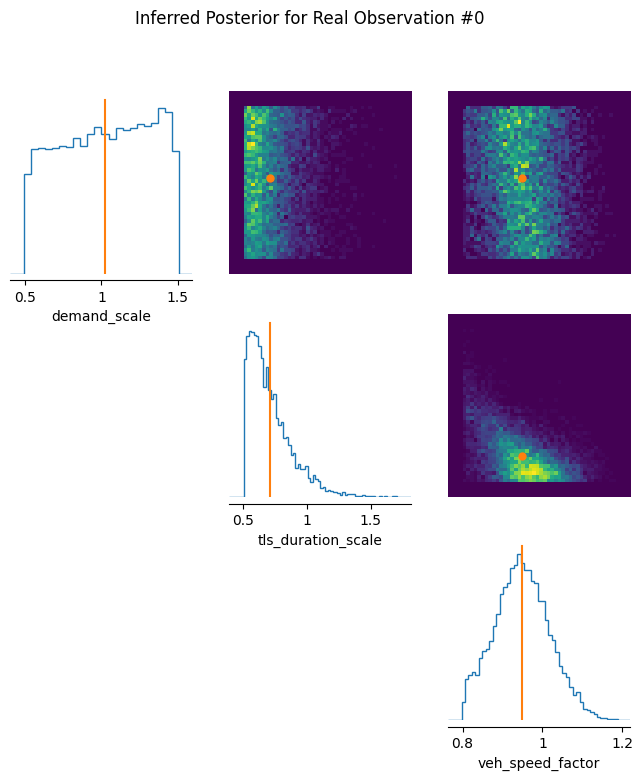

In [1]:
import torch
import pandas as pd
from sbi.analysis import pairplot

# --- 1. Load your trained model and training data for scaling ---
print("Loading model and data for scaling info...")
posterior = torch.load('posterior.pt', weights_only=False)

# We need the original training data to know how to un-scale the results
theta_df_train = pd.read_csv('theta.csv')
theta_min = torch.tensor(theta_df_train.min().values, dtype=torch.float32)
theta_max = torch.tensor(theta_df_train.max().values, dtype=torch.float32)
theta_labels = theta_df_train.columns.tolist()

# --- 2. Pick ONE Observation from your REAL data ---
print("Loading real-world data...")
# !!! IMPORTANT: Change 'real_data.csv' to the name of your file !!!
real_x_df = pd.read_csv('real_data.csv')

# Let's use the very first real observation for this plot
observation_index = 0
x_observed = torch.tensor(real_x_df.iloc[observation_index].values, dtype=torch.float32)

print(f"\nUsing REAL observation #{observation_index} as our target.")
print(f"-> Observed x: {x_observed.numpy()}")

# --- 3. Sample from the Posterior for this observation ---
print("\nSampling from the posterior distribution... this may take a moment.")
posterior_samples = posterior.sample((10000,), x=x_observed)

# Un-scale the samples to get back to the original parameter space
posterior_samples_unscaled = posterior_samples * (theta_max - theta_min) + theta_min
print("Sampling complete.")

# --- 4. Calculate the "Best Guess" (Posterior Mean) ---
# This will be the point we plot on the graph
posterior_mean = torch.mean(posterior_samples_unscaled, dim=0)
print(f"-> Model's Best Guess (Posterior Mean): {posterior_mean.numpy()}")

# --- 5. Visualize the Results ---
print("Generating pair plot for the real observation...")
fig, axes = pairplot(
    posterior_samples_unscaled,
    points=posterior_mean.unsqueeze(0), # Plot the best guess instead of ground truth
    labels=theta_labels,
    figsize=(8, 8)
)
fig.suptitle(f"Inferred Posterior for Real Observation #{observation_index}", y=1.0)
fig.savefig("real_data_posterior_plot.png")

print("\nSuccess! Plot saved to real_data_posterior_plot.png")
print("Send this to your teammate!")

In [2]:
# SCRIPT 1: run_full_inference.py

import torch
import pandas as pd
from tqdm import tqdm

# --- 1. Load Model and Scaling Info ---
print("Loading model and training data for scaling info...")
posterior = torch.load('posterior.pt', weights_only=False)
theta_df_train = pd.read_csv('theta.csv')

theta_min = torch.tensor(theta_df_train.min().values, dtype=torch.float32)
theta_max = torch.tensor(theta_df_train.max().values, dtype=torch.float32)
theta_parameter_names = theta_df_train.columns.tolist()

# --- 2. Load Your REAL-WORLD Data ---
print("Loading real-world observation data...")
# !!! Make sure this filename is correct !!!
real_x_df = pd.read_csv('real_data.csv')
print(f"Found {len(real_x_df)} real-world observations to analyze.")

# --- 3. Perform Inference for EACH Observation ---
results = []
num_samples_per_observation = 2000 # Reduced for speed, still robust

print(f"\nStarting inference loop for {len(real_x_df)} observations...")
for index, row in tqdm(real_x_df.iterrows(), total=len(real_x_df)):
    x_observed = torch.tensor(row.values, dtype=torch.float32)
    posterior_samples = posterior.sample((num_samples_per_observation,), x=x_observed)
    posterior_samples_unscaled = posterior_samples * (theta_max - theta_min) + theta_min

    posterior_mean = torch.mean(posterior_samples_unscaled, dim=0).numpy()
    posterior_std = torch.std(posterior_samples_unscaled, dim=0).numpy()

    result_summary = {}
    for i, name in enumerate(theta_parameter_names):
        result_summary[f'{name}_mean'] = posterior_mean[i]
        result_summary[f'{name}_std'] = posterior_std[i]
    results.append(result_summary)

print("\nInference complete.")

# --- 4. Save Your Results ---
results_df = pd.DataFrame(results)
final_df = pd.concat([real_x_df.reset_index(drop=True), results_df], axis=1)
final_df.to_csv('inference_results.csv', index=False)

print("\nSuccess! Full results saved to 'inference_results.csv'")
print("Now you can run the visualization script.")

Loading model and training data for scaling info...
Loading real-world observation data...
Found 6011 real-world observations to analyze.

Starting inference loop for 6011 observations...


  0%|                                                       | 0/6011 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    997 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
  0%|                                            | 2/6011 [00:13<11:33:32,  6.93s/it]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|                                             | 4/6011 [00:13<4:49:15,  2.89s/it]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|                                            | 5/6011 [01:15<25:06:20, 15.05s/it]


KeyboardInterrupt: 

In [5]:
# diagnose_data.py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
# Make sure these filenames match your files exactly.
REAL_DATA_FILE = 'real_data.csv'
SIMULATED_DATA_FILE = 'x.csv'
# ---------------------

print("--- Data Diagnostic Script ---")

# --- 1. Load Data ---
try:
    real_df = pd.read_csv(REAL_DATA_FILE)
    sim_df = pd.read_csv(SIMULATED_DATA_FILE)
    print(f"Successfully loaded '{REAL_DATA_FILE}' (Shape: {real_df.shape})")
    print(f"Successfully loaded '{SIMULATED_DATA_FILE}' (Shape: {sim_df.shape})")
except FileNotFoundError as e:
    print(f"\nERROR: Could not find a file. Make sure your files are named correctly and in the same folder.")
    print(f"Details: {e}")
    exit()

# --- 2. Sanity Check: Column Names ---
if real_df.columns.tolist() != sim_df.columns.tolist():
    print("\nWARNING: Column names do not match between the two files!")
    print(f"Real data columns: {real_df.columns.tolist()}")
    print(f"Simulated data columns: {sim_df.columns.tolist()}")
    print("Metrics and plots may be misleading. Please ensure columns represent the same features.")
    # For the script to run, we'll use the simulated data's column names as the standard
    # You should fix your files to have matching headers for a proper comparison.
    if len(real_df.columns) == len(sim_df.columns):
        real_df.columns = sim_df.columns
        print("Attempted to align column names for now.")

# --- 3. Calculate and Print Summary Metrics ---
print("\n--- Summary Statistics ---")
# Use .describe() to get all the key metrics at once
real_desc = real_df.describe()
sim_desc = sim_df.describe()

for col in sim_desc.columns:
    print(f"\n--- Comparison for column: '{col}' ---")
    # Combine the two description series for a side-by-side view
    comparison_df = pd.DataFrame({
        'Real Data': real_desc[col],
        'Simulated Data': sim_desc[col]
    })
    print(comparison_df.round(3)) # Round for cleaner output

# --- 4. Generate Visualizations for Each Column ---
print("\n--- Generating Comparison Plots ---")
for col in real_df.columns:
    print(f"Creating plot for '{col}'...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Overlayed Histograms / Density Plots
    sns.histplot(real_df[col], color="skyblue", label="Real Data", kde=True, ax=ax1, alpha=0.6)
    sns.histplot(sim_df[col], color="red", label="Simulated Data", kde=True, ax=ax1, alpha=0.6)
    ax1.set_title(f"Distribution of '{col}'")
    ax1.legend()

    # Plot 2: Side-by-Side Box Plots
    # We need to combine the data into a long-form DataFrame for easy plotting with seaborn
    plot_data = pd.concat([
        pd.DataFrame({'value': real_df[col], 'source': 'Real Data'}),
        pd.DataFrame({'value': sim_df[col], 'source': 'Simulated Data'})
    ])
    sns.boxplot(x='source', y='value', data=plot_data, ax=ax2)
    ax2.set_title(f"Box Plot of '{col}'")

    fig.suptitle(f"Sim-to-Real Comparison for Feature: '{col}'", fontsize=16, y=1.02)
    plt.tight_layout()

    # Save the figure
    plot_filename = f"comparison_plot_{col}.png"
    plt.savefig(plot_filename)
    plt.close(fig) # Close the figure to free up memory
    print(f"-> Saved plot to '{plot_filename}'")

print("\n--- Diagnostic Complete ---")
print("Please review the printed metrics and the saved PNG image files.")

--- Data Diagnostic Script ---
Successfully loaded 'real_data.csv' (Shape: (6011, 3))
Successfully loaded 'x.csv' (Shape: (100, 3))

--- Summary Statistics ---

--- Comparison for column: 'meanSpeed' ---
       Real Data  Simulated Data
count   6011.000         100.000
mean      17.426           6.857
std        9.495           0.469
min        0.600           5.995
25%       11.100           6.473
50%       15.500           6.833
75%       21.700           7.296
max      111.000           7.750

--- Comparison for column: 'meanWaitingTime' ---
       Real Data  Simulated Data
count   6011.000         100.000
mean       9.608           0.935
std       13.083           0.172
min        0.000           0.754
25%        2.631           0.806
50%        5.966           0.912
75%       11.819           0.971
max      261.173           1.515

--- Comparison for column: 'speedFactor' ---
       Real Data  Simulated Data
count   6011.000         100.000
mean       0.395           1.007
std    